In [9]:
%matplotlib inline

import collections
import matplotlib.mlab as mlab
import csv
import pandas as pd
import numpy as np
import scipy as sp
from cvxpy import *
import matplotlib.pyplot as plt
import os
import copy
import sys
import mosek

In [10]:
class species(object):
    def __init__(self, Nres, strat_dist, lin, strat_p=0.1):
        if strat_dist == 'uniform':
            self.strategy = [np.random.uniform() for i in range(Nres)]
        elif strat_dist == 'binomial':
            self.strategy = np.random.choice([0, 1], size=(Nres), p=[1-strat_p, strat_p])
        else:
            print 'Incorrectly specified distribution: options include "uniform" and "binomial".'
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        self.fitness = np.exp(np.random.normal(0, 0.0001))
        self.fit_norm = self.fitness
        self.cost = 1
        self.lineage = lin
        self.barcode = [lin]
        self.frequency = []
    
    def perturb_fitness(self, epsilon):
        self.fitness = self.fitness*np.exp(np.random.normal(0, epsilon))
        #self.fit_norm = self.fitness
        return
    
    def normalize_fitness(self, av_fit):
        self.fit_norm = self.fitness/av_fit
        return
    
    def perturb_strat_rand(self, n=1):
        idx = np.random.choice(range(len(self.strategy)))
        self.strategy[idx] = 1-self.strategy[idx]
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        return
    
    def perturb_strat_dir(self, idx):
        self.strategy[idx] = 1-self.strategy[idx]
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        return
    
    def perturb_strategy_cont(self, epsilon):
        self.strategy = self.strategy+[epsilon*np.random.normal() for i in range(Nres)]
        self.strategy = self.strategy/np.sum(self.strategy)
        return
    
    def rebarcode(self, new_barcode):
        self.barcode.append(new_barcode)
        return
    
    def refrequency(self, frequency):
        self.frequency.append(frequency)
        return

In [11]:
def row_sparsify(A):
    asub = []
    aspec = []
    for i in range(len(A)):
        asub.append([])
        aspec.append([])
        for j in range(len(A[i])):        
            if A[i][j] > 0:
                asub[i].append(j)
                aspec[i].append(A[i][j])
    return asub, aspec

def run_opt(vspecies, vres):
    Nspec = len(vspecies)
    Nres = len(vres)
    
    with mosek.Env() as env:
        with env.Task(0,0) as task:
            
            task.putdouparam(mosek.dparam.intpnt_nl_tol_dfeas,0.0)
            task.putdouparam(mosek.dparam.intpnt_nl_tol_rel_gap,1e-14)
            task.putdouparam(mosek.dparam.intpnt_nl_tol_pfeas,0.0)
            
            numvar = Nres
            numcon = Nspec
            
            inf = 0.0

            bkx = [ mosek.boundkey.lo ] * numvar
            blx = [ 0.0 ] * numvar
            bux = [ inf ] * numvar
            
            bkc = [ mosek.boundkey.up ] * numcon
            buc = [1.0/vspecies[i].fit_norm for i in range(Nspec)]

            task.appendvars(numvar)
            task.appendcons(numcon)

            task.putvarboundslice(0, numvar, bkx, blx, bux)
            
            A = [vspecies[i].strat_norm for i in range(Nspec)]
            asub, aval = row_sparsify(A)
            
            for i in range(numcon):
                task.putbound(mosek.accmode.con,i,bkc[i],-inf,buc[i])
                task.putarow(i, asub[i], aval[i]);

            opro  = [mosek.scopr.log for i in range(Nres)]
            oprjo = range(Nres)
            oprfo = -vres
            oprgo = [1.0 for i in range(Nres)]
            oprho = [0.0 for i in range(Nres)]

            task.putSCeval(opro, oprjo, oprfo, oprgo, oprho)

            task.optimize()

            res = [ 0.0 ] * numvar
            task.getsolutionslice(
                mosek.soltype.itr,
                mosek.solitem.xx,
                0, numvar,
                res)
            
            delta = np.array(A).dot(np.array(res))-np.array(buc)
                
            return res, delta

In [12]:
#def run_opt(vspecies, vres):
#    
#    Nspec = len(vspecies)
#    Nres = len(vres)
#    
#    A = np.array([vspecies[i].fit_norm*vspecies[i].strat_norm for i in range(Nspec)])
#    b = np.array([1 for i in range(Nspec)])
#    h = Variable(Nres)
#
#    obj = Minimize(-sum_entries(vres*log(h)))
#    constraints = [A*h<=b, h>0, h<=5]
#    prob = Problem(obj, constraints)
#    try:
#        prob.solve(solver=ECOS)
#    except:
#        print A
#        print b
#        
#    delta = (np.squeeze(np.asarray(A*h.value))-b)
#    
#    return np.ndarray.flatten(np.asarray(h.value)), delta

# Run random environment with random initial species distribution
def run_rand_env(Nres, alpha):
    Nspec = int(alpha*Nres)
    
    #Normalize influx for rescaled equations
    vres = np.ones(Nres)+np.random.normal(0, 0.01, size=Nres)
    vres = vres/sum(vres)
    vspecies = [species(Nres, 'binomial', i) for i in range(Nspec)]
    h, delta = run_opt(vspecies, vres)

    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    present = []
    absent = []
    
    for i in range(Nspec):
        if np.abs(delta[i])<0.000001:
            present.append(vspecies[i])
        else:
            absent.append(vspecies[i])
    return vres, h, present, absent

# Run specified environment
def run_spec_env(vres, vspecies):
    Nspec = len(vspecies)
    
    #run optimization scheme
    if Nspec == 1:
        h = [vres[i]/vspecies[0].strat_norm[i] for i in range(len(vres))]
        h = h/vspecies[0].fit_norm
        delta = [0]
    else:
        h, delta = run_opt(vspecies, vres)
    
    #presence/absence vector
    present = []
    absent = []
    
    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    for i in range(Nspec):
        if np.abs(delta[i])>1e-8:
            absent.append(vspecies[i])
        else:
            present.append(vspecies[i])
    
    return vres, h, present, absent

def calc_inv_fit(s, h):
    return s.fit_norm*np.dot(s.strat_norm, h)-1

def pick_species(rates, spec_pool, eps_fit):
    temp = np.random.choice(spec_pool, p=rates)
    temp.perturb_fitness(eps_fit)
    return temp

def check_nonneg(rate):
    if rate < 0:
        return 0
    else:
        return rate
    
def draw_time(rate):
    return np.random.exponential(1/rate)

def sswm_evol(vspecies, vres, h, eps_fit):
    spec_pool = []
    inv_fit = []
    for s in vspecies:
        for i in range(len(vres)):
            temp = copy.deepcopy(s)
            temp.perturb_strat_dir(i)
            spec_pool.append(temp)
            inv_fit.append(check_nonneg(calc_inv_fit(temp,h)))
    norm = sum(inv_fit)
    time = 1
    try:
        if norm == 0:
            temp = np.random.choice(spec_pool)
            vspecies.append(temp.perturb_fitness(eps_fit))
            av_fit = 0
            for s in vspecies:
                av_fit=av_fit+s.fitness
            av_fit = av_fit/float(len(vspecies))
            for s in vspecies:
                s.normalize_fitness(av_fit)
        else:
            rates = []
            for i in inv_fit:
                rates.append(float(i)/norm)
            vspecies.append(pick_species(rates, spec_pool, eps_fit))
            time = draw_time(norm)
            av_fit = 0
            for s in vspecies:
                av_fit=av_fit+s.fitness
            av_fit = av_fit/float(len(vspecies))
            for s in vspecies:
                s.normalize_fitness(av_fit)
    except:
        print "whoops!"
    return vspecies, time

def sswm_evol_mut(vspecies, vres, h, eps_fit):
    spec_pool = []
    inv_fit = []
    for s in vspecies:
        for i in range(len(vres)):
            temp = copy.deepcopy(s)
            temp.perturb_strat_dir(i)
            spec_pool.append(temp)
            inv_fit.append(check_nonneg(calc_inv_fit(temp,h)))
    norm = sum(inv_fit)
    if norm == 0:
        temp = np.random.choice(spec_pool)
        temp.perturb_fitness(eps_fit)
        vspecies.append(temp)
        time = 1
        av_fit = 0
        for s in vspecies:
            av_fit=av_fit+s.fitness
        av_fit = av_fit/float(len(vspecies))
        for s in vspecies:
            s.normalize_fitness(av_fit)
    else:
        rates = []
        for i in inv_fit:
            rates.append(float(i)/norm)
        temp = pick_species(rates, spec_pool, eps_fit)
        vspecies.append(temp)
        time = draw_time(norm)
        av_fit = 0
        for s in vspecies:
            av_fit=av_fit+s.fitness
        av_fit = av_fit/float(len(vspecies))
        for s in vspecies:
            s.normalize_fitness(av_fit)
    return vspecies, temp

def runT(Nres, alpha, T, eps_fit):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    #time = []
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        #time.append(t0)
        #rebarcode population
        #counter = 0
        #for j in present:
        #    j.rebarcode(counter)
        #    counter=counter+1
        #requilibrate
        vres, h, present, absent = run_spec_env(vres, present)
    #barcodes = [present[i].barcode for i in range(len(present))]
    return vres, h, present

def runT_mut_track(Nres, alpha, T, eps_fit):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    time = []
    mut = []
    ext = []
    for i in range(T):
        #evolve population
        present, new = sswm_evol_mut(present, vres, h, eps_fit)
        #rebarcode population
        counter = 0
        for j in present:
            j.rebarcode(counter)
            counter=counter+1
        #requilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        mut.append(new)
        ext.append(absent)
    #barcodes = [present[i].barcode for i in range(len(present))]
    return mut, ext

def runT_nspec(Nres, alpha, T, eps_fit):
    nspec = []
    vres, h, present, absent = run_rand_env(Nres, alpha)
    nspec.append(len(present))
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        #time.append(t0)
        #rebarcode population
        #counter = 0
        #for j in present:
        #    j.rebarcode(counter)
        #    counter=counter+1
        #requilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        nspec.append(len(present))
    #barcodes = [present[i].barcode for i in range(len(present))]
    return nspec[T]

def calculate_frequencies(present, vres, h):
    a = np.array([present[i].fit_norm*present[i].strat_norm for i in range(len(present))])
    a = np.transpose(a)
    b = np.array([vres[i]/h[i] for i in range(len(vres))])
    m = sp.optimize.nnls(a, b)[0]
    return m

def runT_freq(Nres, alpha, T, eps_fit):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    m = calculate_frequencies(present, vres, h)
    time = []
    for j in range(len(present)):
        present[j].refrequency(m[j])
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        time.append(t0)
        counter = 0
        for j in present:
            j.rebarcode(counter)
            counter=counter+1
        #re-equilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        #calculate frequencies
        m = calculate_frequencies(present, vres, h)
        for j in range(len(present)):
            present[j].refrequency(m[j])
    return present

def calc_entropy(species):
    ent = 0
    for i in species.strat_norm:
        if i != 0:
            ent = ent - i*np.log(i)
    return ent

def avg_entropy(vspecies):
    tot_ent = 0
    for s in vspecies:
        tot_ent = tot_ent + calc_entropy(s)
    return tot_ent/len(vspecies)

def runT_entropy(Nres, alpha, T, eps_fit):
    av_ent = []
    vres, h, present, absent = run_rand_env(Nres, alpha)
    time = []
    av_ent.append(avg_entropy(present))
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        time.append(t0)
        #re-equilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        av_ent.append(avg_entropy(present))
    return av_ent

def max_min_entropy(present, vres, h):
    m = calculate_frequencies(present, vres, h)
    return calc_entropy(present[np.argmax(m)]), calc_entropy(present[np.argmin(m)])

def runT_MaxMinEnt(Nres, alpha, T, eps_fit):
    maxent = []
    minent = []
    vres, h, present, absent = run_rand_env(Nres, alpha)
    time = []
    maxtemp, mintemp = max_min_entropy(present, vres, h)
    maxent.append(maxtemp)
    minent.append(mintemp)
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        time.append(t0)
        #re-equilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        maxtemp, mintemp = max_min_entropy(present, vres, h)
        maxent.append(maxtemp)
        minent.append(mintemp)
    return maxent, minent

def max_min_fit(present, vres, h):
    m = calculate_frequencies(present, vres, h)
    return present[np.argmax(m)].fit_norm, present[np.argmin(m)].fit_norm

def runT_MaxMinFit(Nres, alpha, T, eps_fit):
    maxfit = []
    minfit = []
    vres, h, present, absent = run_rand_env(Nres, alpha)
    time = []
    maxtemp, mintemp = max_min_fit(present, vres, h)
    maxfit.append(maxtemp)
    minfit.append(mintemp)
    for i in range(T):
        #evolve population
        present, t0 = sswm_evol(present, vres, h, eps_fit)
        time.append(t0)
        #re-equilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        maxtemp, mintemp = max_min_fit(present, vres, h)
        maxfit.append(maxtemp)
        minfit.append(mintemp)
    return maxfit, minfit

In [41]:
Nres=50
alpha = 4
T = 5000
eps_fit = [1/10**3.5, 1/10**2.5, 1/10**1.5]
output3 = []


for e in eps_fit:
    temp = []
    for i in range(10):
        temp.append(runT(Nres, alpha, T, e))
        try:
            temp.append(runT(Nres, alpha, T, e))
            print "Iteration "+str(i)+" of epsilon="+str(e)+" succeeded"
        except:
            print "Iteration "+str(i)+" of epsilon="+str(e)+" failed"
    output3.append(temp)

print len(output3)

Iteration 0 of epsilon=0.000316227766017 succeeded
Iteration 1 of epsilon=0.000316227766017 succeeded
Iteration 2 of epsilon=0.000316227766017 succeeded
Iteration 3 of epsilon=0.000316227766017 succeeded
Iteration 4 of epsilon=0.000316227766017 succeeded
Iteration 5 of epsilon=0.000316227766017 succeeded
Iteration 6 of epsilon=0.000316227766017 succeeded
Iteration 7 of epsilon=0.000316227766017 succeeded
Iteration 8 of epsilon=0.000316227766017 succeeded
Iteration 9 of epsilon=0.000316227766017 succeeded
Iteration 0 of epsilon=0.00316227766017 succeeded
Iteration 1 of epsilon=0.00316227766017 succeeded
Iteration 2 of epsilon=0.00316227766017 succeeded
Iteration 3 of epsilon=0.00316227766017 succeeded
Iteration 4 of epsilon=0.00316227766017 succeeded
Iteration 5 of epsilon=0.00316227766017 succeeded
Iteration 6 of epsilon=0.00316227766017 succeeded
Iteration 7 of epsilon=0.00316227766017 succeeded
Iteration 8 of epsilon=0.00316227766017 succeeded
Iteration 9 of epsilon=0.00316227766017 

In [245]:
print len(output[0][0][2])

9


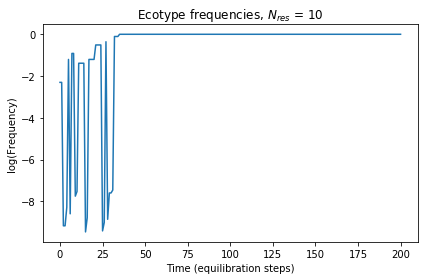

In [157]:
Nres=10
alpha = 4
T = 200
eps_fit = 0.001

present = runT_freq(Nres, alpha, T, eps_fit)

plt.cla()
ax = plt.subplot(111)
for s in present:
    ax.plot(np.log(s.frequency), label='$\epsilon$='+str(eps_fit))
ax.set_title('Ecotype frequencies, $N_{res}$ = 10')
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('log(Frequency)')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.tight_layout()
plt.savefig('logfrequencies'+str(eps_fit)+'_SSWM_10res.pdf', bbox_inches='tight')
plt.show()

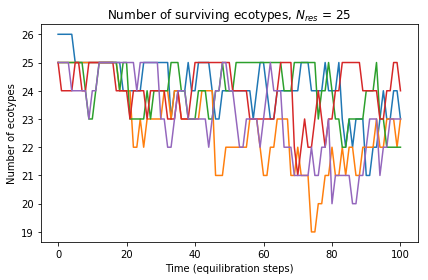

In [243]:
Nres=25
alpha = 4
T = 100
eps_fit = 0.001

nspec_array = []
for i in range(5):
    nspec, time = runT_nspec(Nres, alpha, T, eps_fit)
    nspec_array.append(nspec)

plt.cla()
ax = plt.subplot(111)
for nspec in nspec_array:
    ax.plot(nspec)
ax.set_title('Number of surviving ecotypes, $N_{res}$ = 25')
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Number of ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.tight_layout()
plt.savefig('number_ecotypes'+str(eps_fit)+'_SSWM_stratfit_25res.pdf', bbox_inches='tight')
plt.show()

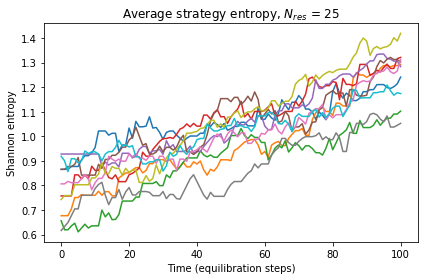

In [245]:
Nres=25
alpha = 6
T = 100
eps_fit = 0.001

av_ent = []
for i in range(10):
    v_ent = runT_entropy(Nres, alpha, T, eps_fit)
    av_ent.append(v_ent)

plt.cla()
ax = plt.subplot(111)
for entropy in av_ent:
    ax.plot(entropy)
ax.set_title('Average strategy entropy, $N_{res}$ = 25')
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Shannon entropy')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.tight_layout()
plt.savefig('entropy'+str(eps_fit)+'_SSWM_stratfit_25res_10_100.pdf', bbox_inches='tight')
plt.show()

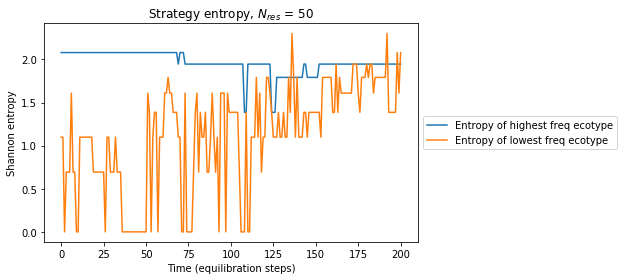

In [248]:
Nres=50
alpha = 6
T = 200
eps_fit = 0.001

maxent, minent = runT_MaxMinEnt(Nres, alpha, T, eps_fit)

plt.cla()
ax = plt.subplot(111)
ax.plot(maxent, label='Entropy of highest freq ecotype')
ax.plot(minent, label='Entropy of lowest freq ecotype')
ax.set_title('Strategy entropy, $N_{res}$ = 50')
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Shannon entropy')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('maxminentropy'+str(eps_fit)+'_SSWM_50res_200.pdf', bbox_inches='tight')
plt.show()

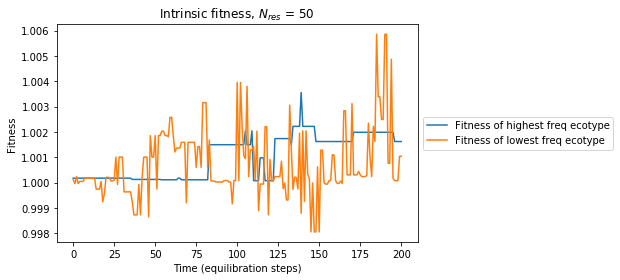

In [249]:
Nres=50
alpha = 6
T = 200
eps_fit = 0.001

maxent, minent = runT_MaxMinFit(Nres, alpha, T, eps_fit)

plt.cla()
ax = plt.subplot(111)
ax.plot(maxent, label='Fitness of highest freq ecotype')
ax.plot(minent, label='Fitness of lowest freq ecotype')
ax.set_title('Intrinsic fitness, $N_{res}$ = 50')
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Fitness')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('maxminfit'+str(eps_fit)+'_SSWM_50res_200.pdf', bbox_inches='tight')
plt.show()

In [261]:
Nres=50
alpha = 4
T = 100
eps_fit = [0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001]

nspec_array = []
eps_array = []

for e in eps_fit:
    for i in range(5):
        nspec, time = runT_nspec(Nres, alpha, T, eps_fit)
        nspec_array.append(nspec)
        eps_array.append(e)

plt.cla()
ax = plt.subplot(111)
ax.plot(eps_array, nspec_array)
#ax.set_title('Number of surviving ecotypes, $N_{res}$ = 25')
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Number of surviving ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.tight_layout()
plt.savefig('number_ecotypes'+str(eps_fit)+'_SSWM_stratfit_vareps_50res.pdf', bbox_inches='tight')
plt.show()

1.00007940162 [ 0.          0.          0.          0.          0.          0.
  0.14285714  0.          0.          0.14285714  0.          0.          0.
  0.          0.          0.          0.          0.14285714  0.          0.
  0.          0.          0.14285714  0.          0.14285714  0.
  0.14285714  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.14285714  0.          0.          0.          0.          0.
  0.          0.          0.        ]
0.999942456421 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.25  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.25  0.    0.    0.    0.    0.25]
1.00004966258 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.

ValueError: operands could not be broadcast together with shapes (6,) (50,) 

In [101]:
Nres=50
alpha = 4
T = 10000
eps_fit = [0.0001, 0.001, 0.01, 0.1]
output = []

for eps in eps_fit:
    tempn = []
    for i in range(10):
        try:
            tempn.append(runT_nspec(Nres, alpha, T, eps))
        except:
            print "Iteration "+str(i)+" of epsilon="+str(eps)+" failed"
    output.append(tempn)
    
print n50000

Combined backtracking failed 0 72 12 6 sigma 0.966181
Combined backtracking failed 20 0 65 5 sigma 1
Combined backtracking failed 21 0 66 3 sigma 1
Combined backtracking failed 0 66 18 6 sigma 1
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 1 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 2 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 3 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 4 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 5 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 6 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 9 of epsilon=0.01 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 0 of epsilon=0.1 failed
Combined backtracking failed 0 0 90 0 sigma 1
Iteration 1 of epsilon=0.1 failed
Combined backtracking failed 0 0 88 2 sigma 0.027073
Iteration 2 of epsilon=0.

In [78]:
print n

[[49, 48, 49, 49, 49, 47, 49, 48, 47, 48], [42, 44, 40, 43, 43, 43, 42, 44, 44, 44], [31, 34, 33, 33, 34, 34, 35, 34, 37, 38], [11, 9, 9, 11, 10, 9, 10, 9, 10, 7]]


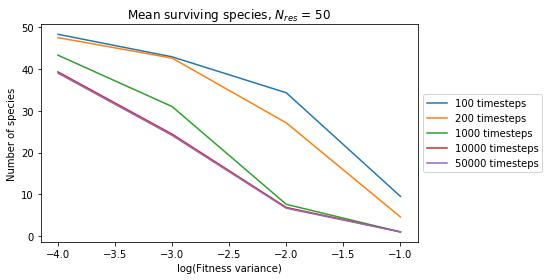

In [103]:
n_av = [np.mean(i) for i in n]
n200_av = [np.mean(i) for i in n200]

plt.cla()
ax = plt.subplot(111)
ax.plot(np.log10(eps_fit), n_av, label='100 timesteps')
ax.plot(np.log10(eps_fit), n200_av, label='200 timesteps')
ax.plot(np.log10(eps_fit), n1000_av, label='1000 timesteps')
ax.plot(np.log10(eps_fit), n10000_av, label='10000 timesteps')
ax.plot(np.log10(eps_fit), n50000_av, label='50000 timesteps')
ax.set_title('Mean surviving species, $N_{res}$ = 50')
ax.set_xlabel('log(Fitness variance)')
ax.set_ylabel('Number of species')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('surviving_species_init.pdf', bbox_inches='tight')
plt.show()


In [88]:
n1000_av = [np.mean(i) for i in n1000]
n1000_av = n1000_av[:3]
n1000_av.append(1)
print n1000_av

[43.299999999999997, 31.0, 7.5999999999999996, 1]


In [102]:
n50000_av = [np.mean(i) for i in n50000]
n50000_av = n50000_av[:3]
n50000_av.append(1)
print n50000_av

[39.0, 24.100000000000001, 6.666666666666667, 1]


In [106]:
print n
print n200
print n1000_av
print n10000_av
print n50000_av


[[49, 48, 49, 49, 49, 47, 49, 48, 47, 48], [42, 44, 40, 43, 43, 43, 42, 44, 44, 44], [31, 34, 33, 33, 34, 34, 35, 34, 37, 38], [11, 9, 9, 11, 10, 9, 10, 9, 10, 7]]
[[46, 49, 47, 46, 49, 47, 47, 48, 48, 48], [43, 44, 44, 42, 42, 39, 40, 44, 44, 44], [29, 28, 23, 23, 30, 30, 29, 27, 27, 25], [4, 3, 8, 5, 4, 4, 4]]
[43.299999999999997, 31.0, 7.5999999999999996, 1]
[39.299999999999997, 24.399999999999999, 6.8571428571428568, 1]
[39.0, 24.100000000000001, 6.666666666666667, 1]


ValueError: object too deep for desired array

In [122]:
print absent[3]

[[<__main__.species object at 0x114050c10>, <__main__.species object at 0x113e1ee90>, <__main__.species object at 0x11400b350>, <__main__.species object at 0x11400b790>, <__main__.species object at 0x113f2d1d0>, <__main__.species object at 0x1140401d0>, <__main__.species object at 0x114040a10>, <__main__.species object at 0x114040310>, <__main__.species object at 0x113c4b8d0>, <__main__.species object at 0x113c9c390>, <__main__.species object at 0x114055e10>, <__main__.species object at 0x113e4ea10>], [<__main__.species object at 0x114050ed0>], [<__main__.species object at 0x114050950>, <__main__.species object at 0x114055090>], [], [<__main__.species object at 0x114056e10>], [<__main__.species object at 0x11431c510>], [<__main__.species object at 0x113e4e550>], [<__main__.species object at 0x110d58a90>], [<__main__.species object at 0x113e1ee50>, <__main__.species object at 0x113dbdb50>], [<__main__.species object at 0x113e4efd0>], [<__main__.species object at 0x114050290>, <__main__.

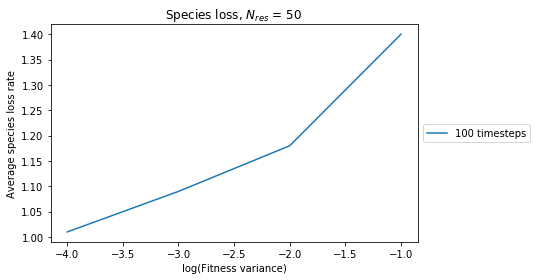

In [127]:
avo = []
for i in absent:
    temp = []
    for j in i:
        temp.append(len(j))
    avo.append(np.mean(temp))

plt.cla()
ax = plt.subplot(111)
ax.plot(np.log10(eps_fit), avo, label='100 timesteps')
ax.set_title('Species loss, $N_{res}$ = 50')
ax.set_xlabel('log(Fitness variance)')
ax.set_ylabel('Average species loss rate')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('species_loss.pdf', bbox_inches='tight')
plt.show()

In [165]:

for i in range(len(absent[0])):
    print len(absent[0][i])
    for j in absent[0][i]:
        print mut[0][i].fitness, j.fitness, mut[2][i].strategy, j.strategy

1
0.99997329845 0.99997329845 [0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
1
1.00023272729 1.0000082077 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
1
1.00009128102 1.00013426296 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0] [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
2
1.00011777926 1.00006243988 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0] [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]
1.00011777926 1.00019698207 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [134]:
print mut[1]

[<__main__.species object at 0x113f79a50>, <__main__.species object at 0x113e66510>, <__main__.species object at 0x1142619d0>, <__main__.species object at 0x1142987d0>, <__main__.species object at 0x1142b6d90>, <__main__.species object at 0x114243710>, <__main__.species object at 0x1140b8310>, <__main__.species object at 0x1140b8510>, <__main__.species object at 0x1141ebe90>, <__main__.species object at 0x113da7610>, <__main__.species object at 0x11406e6d0>, <__main__.species object at 0x11412c110>, <__main__.species object at 0x114279210>, <__main__.species object at 0x114279b10>, <__main__.species object at 0x113e1ed10>, <__main__.species object at 0x114290d90>, <__main__.species object at 0x113f79050>, <__main__.species object at 0x1142af290>, <__main__.species object at 0x114066210>, <__main__.species object at 0x1142b6b10>, <__main__.species object at 0x1140b3650>, <__main__.species object at 0x1142b6850>, <__main__.species object at 0x114050310>, <__main__.species object at 0x114

In [166]:
np.mean([])

nan

In [257]:
np.zeros(2)

array([ 0.,  0.])

In [15]:
print output

[[(array([ 0.02017505,  0.02001563,  0.01972173,  0.01956716,  0.02018318,
        0.01962952,  0.02001615,  0.01999033,  0.01993733,  0.01973073,
        0.01994652,  0.01951857,  0.02021714,  0.01991191,  0.02019544,
        0.01981714,  0.02017455,  0.01983695,  0.02007405,  0.02000685,
        0.01989276,  0.02002515,  0.020399  ,  0.01956285,  0.01988704,
        0.0199347 ,  0.01992446,  0.02052644,  0.01986006,  0.02016094,
        0.0196937 ,  0.020062  ,  0.02012454,  0.02031227,  0.02028945,
        0.02022764,  0.02009819,  0.01980447,  0.02037872,  0.02037074,
        0.01980074,  0.01989546,  0.02003165,  0.01975607,  0.02023058,
        0.01988875,  0.02012304,  0.02017372,  0.020202  ,  0.01969692]), [0.99718123288035154, 0.99412580514829185, 0.99913687702070653, 1.0072157231168597, 1.0008016168576446, 0.99524040288384941, 0.99297418260769388, 1.0020015935031472, 1.00128124481958, 0.99903395615333146, 1.000687617056722, 1.0074205599457733, 0.99904413693750371, 1.00294014

In [16]:
print len(output)

4


In [42]:
nspec = []

for i in output:
    temp = []
    for j in i:
        temp.append(len(j[2]))
    nspec.append(temp)

nspec2 = []

for i in output2:
    temp = []
    for j in i:
        temp.append(len(j[2]))
    nspec2.append(temp)
    
print nspec
print nspec2

[[40, 39, 37, 37, 36, 44, 43, 39, 38, 37, 36, 41, 39, 37, 39, 38, 40, 39, 40, 38], [17, 29, 22, 22, 26, 26, 19, 23, 24, 4, 23, 23, 22, 21, 25, 27, 26, 29, 27, 26], [4, 5, 4, 2, 10, 1, 10, 9, 6, 6, 2, 7, 6, 10, 2, 3, 5, 6, 5, 3], [2, 1, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 1, 1, 1, 2, 2, 2, 2, 2]]
[[34, 36, 39, 36, 32, 35, 28, 30, 36, 31, 32, 32, 30, 30, 37, 34, 29, 36, 35, 33], [20, 16, 10, 13, 12, 12, 13, 4, 2, 14, 6, 11, 4, 11, 23, 22, 7, 12, 16, 14], [5, 4, 2, 3, 2, 3, 1, 1, 3, 4, 2, 1, 2, 1, 4, 2, 2, 3, 3, 1]]


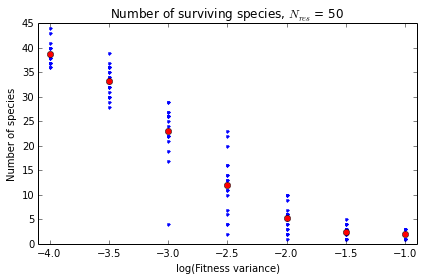

In [50]:
eps_fit = [-4,-3,-2,-1]
eps_fit2 = [-3.5, -2.5, -1.5]

ax = plt.subplot(111)

for i in range(4):
    for j in nspec[i]:
        ax.plot(eps_fit[i], j, '.', color = 'b')
    ax.plot(eps_fit[i],np.mean(nspec[i]),'o', color='r')

for i in range(3):
    for j in nspec2[i]:
        ax.plot(eps_fit2[i], j, '.', color = 'b')
    ax.plot(eps_fit2[i],np.mean(nspec2[i]),'o', color='r')

ax.set_xlim(-4.1, -0.9)
ax.set_title('Number of surviving species, $N_{res}$ = 50')
ax.set_xlabel('log(Fitness variance)')
ax.set_ylabel('Number of species')
plt.tight_layout()
plt.savefig('surviving_species.pdf', bbox_inches='tight')
plt.show()

In [56]:
h = []

for i in output:
    temp = []
    for j in i:
        temp.append(j[1])
    h.append(temp)

h2 = []

for i in output2:
    temp = []
    for j in i:
        temp.append(j[1])
    h2.append(temp)

vres = []

for i in output:
    temp = []
    for j in i:
        temp.append(j[0])
    vres.append(temp)

vres2 = []

for i in output2:
    temp = []
    for j in i:
        temp.append(j[0])
    vres2.append(temp)
    
pres = []

for i in output:
    temp = []
    for j in i:
        temp.append(j[2])
    pres.append(temp)

pres2 = []

for i in output2:
    temp = []
    for j in i:
        temp.append(j[2])
    pres2.append(temp)

freq = []

for i in output:
    temp = []
    for j in i:
        temp.append(calculate_frequencies(j[2], j[0], j[1]))
    freq.append(temp)

freq2 = []

for i in output2:
    temp = []
    for j in i:
        temp.append(calculate_frequencies(j[2], j[0], j[1]))
    freq2.append(temp)

In [71]:
def plot_survival(data, ax, l):
    sorted_data = np.sort(data)
    # Cumulative counts:
    ax.step(np.concatenate([sorted_data[::-1], sorted_data[[0]]]),
             np.arange(sorted_data.size+1), label = l)


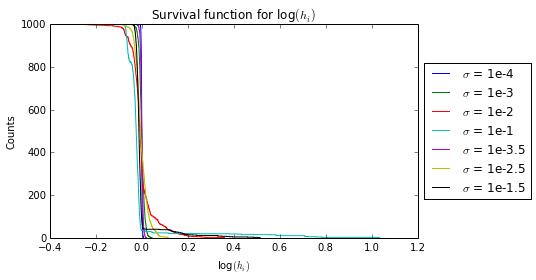

In [74]:
eps_fit = ['$\sigma$ = 1e-4','$\sigma$ = 1e-3','$\sigma$ = 1e-2','$\sigma$ = 1e-1']
eps_fit2 = ['$\sigma$ = 1e-3.5', '$\sigma$ = 1e-2.5', '$\sigma$ = 1e-1.5']

ax = plt.subplot(111)

for i in range(len(eps_fit)):
    hlist = [np.log10(item) for sublist in h[i] for item in sublist]
    plot_survival(hlist, ax, eps_fit[i])

for i in range(len(eps_fit2)):
    hlist = [np.log10(item) for sublist in h2[i] for item in sublist]
    plot_survival(hlist, ax, eps_fit2[i])

ax.set_title('Survival function for log$(h_i)$')
ax.set_xlabel('log$(h_i)$')
ax.set_ylabel('Counts')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('h_survival.pdf', bbox_inches='tight')
plt.show()

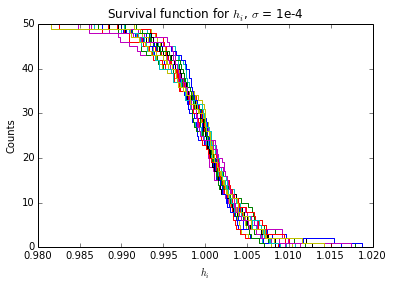

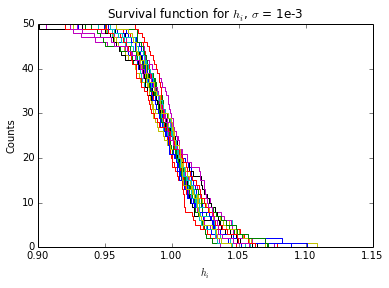

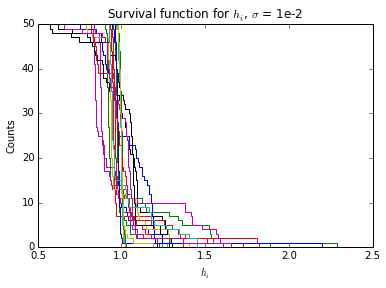

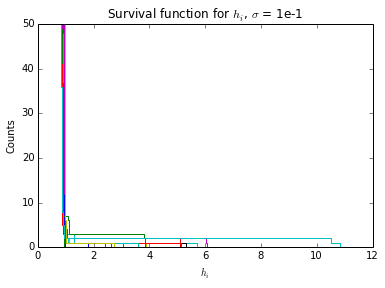

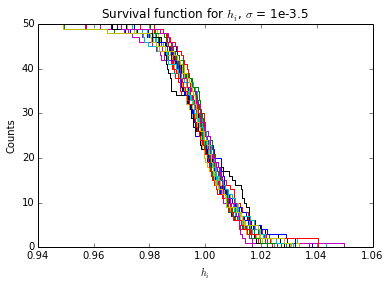

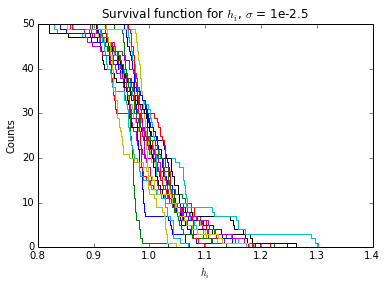

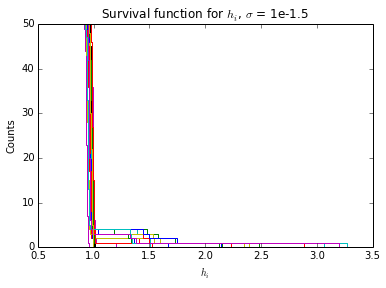

In [91]:
eps_fit = ['$\sigma$ = 1e-4','$\sigma$ = 1e-3','$\sigma$ = 1e-2','$\sigma$ = 1e-1']
eps_fit2 = ['$\sigma$ = 1e-3.5', '$\sigma$ = 1e-2.5', '$\sigma$ = 1e-1.5']

def plot_survival(data, l):
    sorted_data = np.sort(data)
    # Cumulative counts:
    plt.step(np.concatenate([sorted_data[::-1], sorted_data[[0]]]),
             np.arange(sorted_data.size+1), label = l)

for i in range(len(eps_fit)):
    ax = plt.subplot(111)
    for j in h[i]:
        plot_survival(j, eps_fit[i])
    ax.set_title('Survival function for $h_i$, '+eps_fit[i])
    ax.set_xlabel('$h_i$')
    ax.set_ylabel('Counts')
    #plt.savefig('logh_survival'+str(i)+'.pdf')
    plt.show()

for i in range(len(eps_fit2)):
    ax = plt.subplot(111)
    for j in h2[i]:
        plot_survival(j, eps_fit[i])
    ax.set_title('Survival function for $h_i$, '+eps_fit2[i])
    ax.set_xlabel('$h_i$')
    ax.set_ylabel('Counts')
    #plt.savefig('logh_survival'+str(i+4)+'.pdf')
    plt.show()

#ax.set_title('Survival function for log$(h_i)$')
#ax.set_xlabel('log$(h_i)$')
#ax.set_ylabel('Counts')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('h_survival.pdf', bbox_inches='tight')
#plt.show()

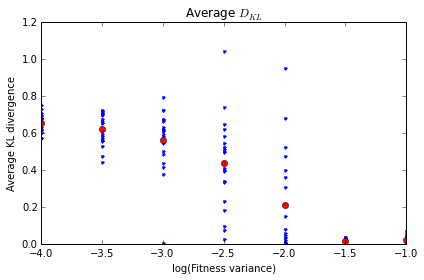

In [127]:
eps_fit = [-4,-3,-2,-1]
eps_fit2 = [-3.5, -2.5, -1.5]

def zlog(strat):
    out = []
    for i in strat:
        if i > 0:
            out.append(np.log(i))
        if i == 0:
            out.append(0)
    return np.array(out)

def KLdiv(spec, vres):
    strat = np.array(spec.strat_norm)
    vres = np.array(vres)
    return strat.dot(zlog(strat)-np.log(vres))

ax = plt.subplot(111)

for i in range(len(pres)):
    temp = []
    for j in range(len(pres[i])):
        avKLdiv = 0
        for k in range(len(pres[i][j])):
            avKLdiv+=freq[i][j][k]*KLdiv(pres[i][j][k], vres[i][j])
        temp.append(avKLdiv)
        ax.plot(eps_fit[i], avKLdiv,'.', color='b')
    ax.plot(eps_fit[i], np.mean(temp),'o', color='r')
        
for i in range(len(pres2)):
    temp = []
    for j in range(len(pres2[i])):
        avKLdiv = 0
        for k in range(len(pres2[i][j])):
            avKLdiv+=freq2[i][j][k]*KLdiv(pres2[i][j][k], vres2[i][j])
        temp.append(avKLdiv)
        ax.plot(eps_fit2[i], avKLdiv,'.', color='b')
    ax.plot(eps_fit2[i], np.mean(temp),'o', color='r')


ax.set_title('Average $D_{KL}$')
ax.set_xlabel('log(Fitness variance)')
ax.set_ylabel('Average KL divergence')
plt.tight_layout()
plt.savefig('AvgKLdiv.pdf', bbox_inches='tight')
plt.show()



In [ ]:
eps_fit = ['$\sigma$ = 1e-4','$\sigma$ = 1e-3','$\sigma$ = 1e-2','$\sigma$ = 1e-1']
eps_fit2 = ['$\sigma$ = 1e-3.5', '$\sigma$ = 1e-2.5', '$\sigma$ = 1e-1.5']

def plot_survival(data, l):
    sorted_data = np.sort(data)
    # Cumulative counts:
    plt.step(np.concatenate([sorted_data[::-1], sorted_data[[0]]]),
             np.arange(sorted_data.size+1), label = l)

for i in range(len(eps_fit)):
    ax = plt.subplot(111)
    for j in h[i]:
        plot_survival(j, eps_fit[i])
    ax.set_title('Survival function for $h_i$, '+eps_fit[i])
    ax.set_xlabel('$h_i$')
    ax.set_ylabel('Counts')
    #plt.savefig('logh_survival'+str(i)+'.pdf')
    plt.show()

for i in range(len(eps_fit2)):
    ax = plt.subplot(111)
    for j in h2[i]:
        plot_survival(j, eps_fit[i])
    ax.set_title('Survival function for $h_i$, '+eps_fit2[i])
    ax.set_xlabel('$h_i$')
    ax.set_ylabel('Counts')
    #plt.savefig('logh_survival'+str(i+4)+'.pdf')
    plt.show()